In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.stats import binned_statistic_2d

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [30]:
cd ..

/home/ck/pythonWorkspace


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [40]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask] 
    sh = np.array(dic['shear'])[mask]  # 925-650 hPa shear
    umin = np.array(dic['u650'])[mask] # minimum 650hPa zonal wind 
    umax = np.array(dic['u925'])[mask] # maximum 925hPa zonal wind
    qq = np.array(dic['q925'])[mask]   # 925hPa spec humidity
    qup = np.array(dic['q650'])[mask]  # 650hPa spec humidity
    tlow = np.array(dic['t925'])[mask] # 925hPa temperature
    tt = np.array(dic['tmin'])[mask]   # minimum cloud top temperature
    ttm = np.array(dic['tmean'])[mask] # mean cloud top temperature
    month = np.array(dic['month'])[mask] 
    hour = np.array(dic['hour'])[mask]
    year = np.array(dic['year'])[mask]
   # minute = np.array(dic['minute'])[mask]
    day = np.array(dic['day'])[mask]
    date = np.array(dic['date'])[mask]
    area = np.array(dic['area'])[mask] # -50C storm area
    lat = np.array(dic['clat'])[mask] # location of minimum temperature
    lon = np.array(dic['clon'])[mask] # location of minimum temperature
    tcwv = np.array(dic['tcwv'])[mask] # total column water vapour
    rh = np.array(dic['rh925'])[mask] # 925hPa relative humidity
    #pall = np.array(dic['p'])[mask] # precipitation field within -50C cloud area


    obs_pcp = {
        'prcp' : pp,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        'shear' : sh*-1,
        'month' : month,    
        'hour' : hour,
        'year' : year,
      #  'minute' : minute,
        'day' : day,
        'date' : date,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        'tcwv' : tcwv,
        'lat' : lat,
        'lon' : lon,
        #'pall' : pall
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

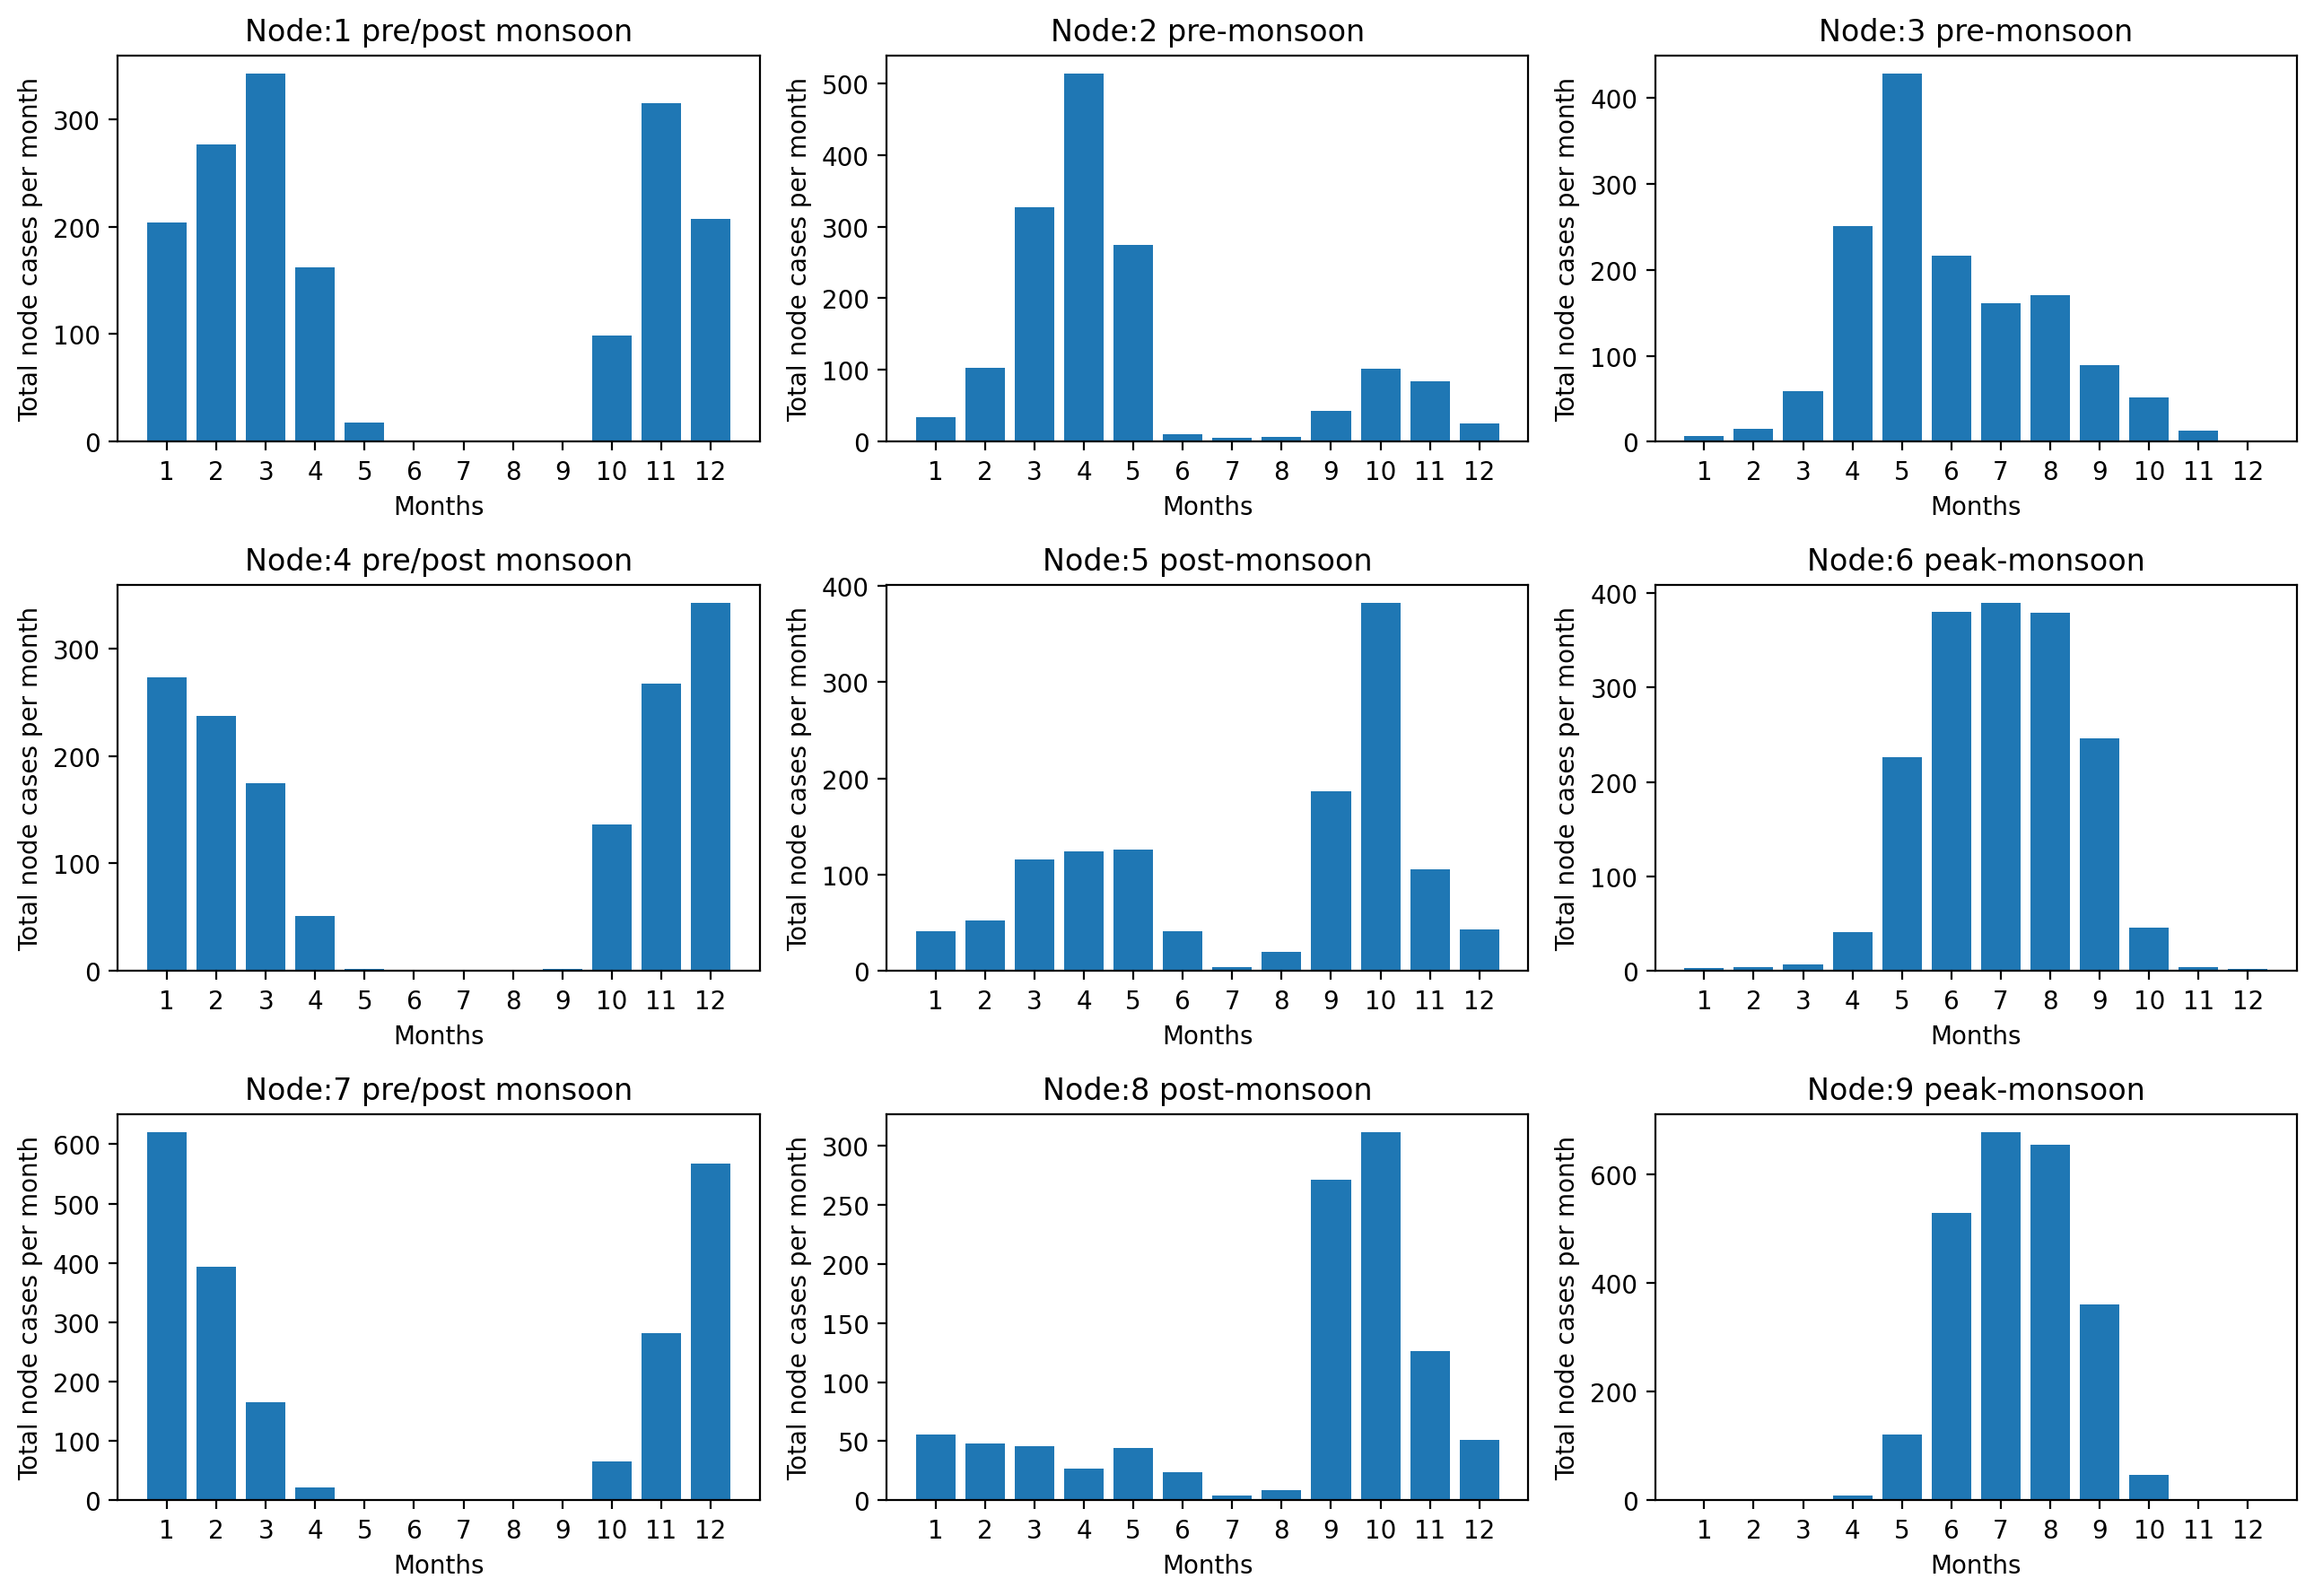

In [33]:
all_node_file = pkl.load(open(cnst.network_data + 'data/SOMS/saves/3x3_Nodes_fullYear/node_days.p', "rb"))

merged_nodes_str = ['pre/post monsoon', 'pre-monsoon', 'pre-monsoon', 'pre/post monsoon', 'post-monsoon', 'peak-monsoon', 'pre/post monsoon', 'post-monsoon', 'peak-monsoon']

f = plt.figure(figsize=(13,9), dpi=200)
for node in range(1,10):
    nmonth = []
    ax = f.add_subplot(3,3,node)
    nodestr = 'node'+str(node)
    ndates = all_node_file[nodestr]
    for ni in range(1,13):
        nmonth.append(np.sum(ndates.month==ni))
    ax.bar(np.arange(1,13).astype(int), np.array(nmonth))
    ax.set_ylabel('Total node cases per month')
    ax.set_xlabel('Months')
    ax.set_title('Node:'+ str(node)+' '+merged_nodes_str[node-1])
    ax.set_xticks(np.arange(1,13).astype(int))
    
plt.tight_layout()
#f.savefig(cnst.network_data + 'figs/SOMS/nb_node_permonth_nodes_fullYear.jpg')

In [34]:
#file_path = cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_hourly_wDate_*.p'

In [35]:
file_path = cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-10N_10W10E_p15_ERA0.7_fullYear*.p'

In [36]:
node_days = pkl.load(open(cnst.network_data + 'data/SOMS/saves/3x3_Nodes_fullYear/node_days.p', "rb"))

In [37]:
#shows available variables in raw dataset
testread = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-10N_10W10E_p15_ERA0.7_fullYear_hourly_SOMS_2004.p', 'rb'))
print(testread.keys())
#del testread

dict_keys(['hour', 'month', 'year', 'day', 'date', 'area', 'lon', 'lat', 'clon', 'clat', 'minlon', 'minlat', 'tmin', 'tmean', 'tcwv', 'pmax', 'pmean', 'q925', 'q650', 'u925', 'u650', 'v925', 'v650', 'w925', 'w650', 'rh925', 'rh650', 't925', 't650', 'div925', 'div650', 'pv925', 'pv650', 'shear', 'pgt30', 'pgt01isvalid', 't', 'p', 'cape', 't2m'])


In [38]:
glob.glob(file_path)

['/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-10N_10W10E_p15_ERA0.7_fullYear_hourly_SOMS_2007.p',
 '/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-10N_10W10E_p15_ERA0.7_fullYear_hourly_SOMS_2010.p',
 '/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-10N_10W10E_p15_ERA0.7_fullYear_hourly_SOMS_2006.p',
 '/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-10N_10W10E_p15_ERA0.7_fullYear_hourly_SOMS_2015.p',
 '/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-10N_10W10E_p15_ERA0.7_fullYear_hourly_SOMS_2012.p',
 '/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-10N_10W10E_p15_ERA0.7_fullYear_hourly_SOMS_2005.p',
 '/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-10N_10W10E_p15_ERA0.7_fullYear_hourly_SOMS_2004.p',
 '/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5-10N_10W10E_p15_ERA0.7_fullYear_hourly_SOMS_2014.p',
 '/home/ck/DIR/cornkle//data/CLOVER/saves/bulk_-50_5000km2_GPM_5

In [39]:
ds = glob.glob(file_path)

for ids, dss in enumerate(ds):
    data = pkl.load( open (dss, 'rb'))

    obs_gpmf_h = create_dic(data)
    if ids > 0:
        obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
    else:
        obs_gpmf = obs_gpmf_h

    del data

KeyError: 'minute'

In [15]:
obs = obs_gpmf[obs_gpmf.prcp>5]

In [16]:
obs

,prcp,q925,q650,t925,shear,month,hour,year,day,date,area,tmin,rh,tcwv,lat,lon
0,7.657979,14.724190,4.140953,25.701318,6.841075,1,17,2007,28,2007-01-28 17:30:00,6325,-75.300844,65.575134,38.754639,7.356987,-1.882976
2,15.055140,14.724190,4.140953,25.701318,6.841075,1,18,2007,28,2007-01-28 18:30:00,11500,-69.499090,65.575134,38.754639,7.404227,-2.109662
3,5.943133,15.173133,4.058833,25.401636,5.112180,1,17,2007,29,2007-01-29 17:30:00,5975,-72.302664,68.002640,40.713509,6.358965,-0.271936
4,36.356035,16.458932,5.158984,23.484399,10.712464,1,17,2007,29,2007-01-29 17:30:00,9325,-63.217142,84.037170,44.086544,7.397655,-7.537494
5,7.684593,16.889343,4.339702,21.651758,11.828568,1,16,2007,31,2007-01-31 16:00:00,12050,-78.338737,96.645584,51.395821,5.408220,-7.923906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,12.618616,17.474011,4.316392,22.397241,9.893822,12,17,2008,17,2008-12-17 17:00:00,5650,-81.180647,95.546036,48.703316,5.587612,7.445095
2673,12.350243,16.071051,4.687850,23.121545,9.465675,12,17,2008,17,2008-12-17 17:00:00,5350,-76.991820,83.916214,48.527660,6.088415,-0.980034
2674,44.925868,16.082516,6.127825,20.624200,7.371384,12,17,2008,18,2008-12-18 17:00:00,55575,-83.975624,96.535057,52.119255,5.832236,-7.297491
2675,43.569980,16.232213,5.767504,22.369257,8.320564,12,17,2008,18,2008-12-18 17:00:00,13200,-77.568508,88.686577,53.128746,5.710372,-4.322611


In [17]:
u, inv = np.unique(obs.date, return_inverse=True)
n = np.bincount(inv)

(array([   0., 2667., 1934., 1425.,  855.,  510.,  330.,  186.,  168.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <BarContainer object of 9 artists>)

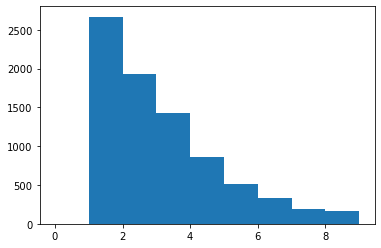

In [18]:
plt.hist(n, bins=range(0,10,1))

In [19]:
node_days['node1'].values

array(['1981-01-24T00:00:00.000000000', '1981-02-18T00:00:00.000000000',
       '1981-02-19T00:00:00.000000000', ...,
       '2020-12-28T00:00:00.000000000', '2020-12-29T00:00:00.000000000',
       '2020-12-30T00:00:00.000000000'], dtype='datetime64[ns]')

In [20]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

9.285335968843109
5.183088208003307
9.791336424340532
-9.884628690428471


In [21]:
obs_gpmf.year

0       2007
1       2007
2       2007
3       2007
4       2007
        ... 
2674    2008
2675    2008
2676    2008
2677    2008
2678    2008
Name: year, Length: 26720, dtype: int64

In [22]:
node_mcs_days = {}
nb_node = 9
for n in range(1,nb_node+1):
    nstr = 'node'+str(n)
    node_mcs_days[nstr] = []
    nday = node_days[nstr]
    for ndate in nday:
        posis = ((ndate.year) == obs['year']) & ((ndate.month) == obs['month']) & ((ndate.day) == obs['day'])
        
        node_mcs_days[nstr].extend(obs['date'].values[posis])

In [23]:
obs_ind = obs.set_index('date')

In [24]:
node_mcs_days

{'node1': [numpy.datetime64('2004-02-18T18:30:00.000000000'),
  numpy.datetime64('2004-02-18T18:30:00.000000000'),
  numpy.datetime64('2004-03-01T17:30:00.000000000'),
  numpy.datetime64('2004-03-01T17:30:00.000000000'),
  numpy.datetime64('2004-03-01T17:30:00.000000000'),
  numpy.datetime64('2004-03-01T18:00:00.000000000'),
  numpy.datetime64('2004-03-01T18:00:00.000000000'),
  numpy.datetime64('2004-03-01T18:00:00.000000000'),
  numpy.datetime64('2004-03-01T18:00:00.000000000'),
  numpy.datetime64('2004-03-01T18:00:00.000000000'),
  numpy.datetime64('2004-03-01T18:00:00.000000000'),
  numpy.datetime64('2004-03-01T18:00:00.000000000'),
  numpy.datetime64('2004-03-03T17:30:00.000000000'),
  numpy.datetime64('2004-03-03T18:30:00.000000000'),
  numpy.datetime64('2004-03-03T18:30:00.000000000'),
  numpy.datetime64('2004-03-03T18:30:00.000000000'),
  numpy.datetime64('2004-03-03T18:30:00.000000000'),
  numpy.datetime64('2004-03-17T17:00:00.000000000'),
  numpy.datetime64('2004-03-17T17:00:

In [25]:
obs_ind

,prcp,q925,q650,t925,shear,month,hour,year,day,area,tmin,rh,tcwv,lat,lon
date,,,,,,,,,,,,,,,
2007-01-28 17:30:00,7.657979,14.724190,4.140953,25.701318,6.841075,1,17,2007,28,6325,-75.300844,65.575134,38.754639,7.356987,-1.882976
2007-01-28 18:30:00,15.055140,14.724190,4.140953,25.701318,6.841075,1,18,2007,28,11500,-69.499090,65.575134,38.754639,7.404227,-2.109662
2007-01-29 17:30:00,5.943133,15.173133,4.058833,25.401636,5.112180,1,17,2007,29,5975,-72.302664,68.002640,40.713509,6.358965,-0.271936
2007-01-29 17:30:00,36.356035,16.458932,5.158984,23.484399,10.712464,1,17,2007,29,9325,-63.217142,84.037170,44.086544,7.397655,-7.537494
2007-01-31 16:00:00,7.684593,16.889343,4.339702,21.651758,11.828568,1,16,2007,31,12050,-78.338737,96.645584,51.395821,5.408220,-7.923906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-17 17:00:00,12.618616,17.474011,4.316392,22.397241,9.893822,12,17,2008,17,5650,-81.180647,95.546036,48.703316,5.587612,7.445095
2008-12-17 17:00:00,12.350243,16.071051,4.687850,23.121545,9.465675,12,17,2008,17,5350,-76.991820,83.916214,48.527660,6.088415,-0.980034
2008-12-18 17:00:00,44.925868,16.082516,6.127825,20.624200,7.371384,12,17,2008,18,55575,-83.975624,96.535057,52.119255,5.832236,-7.297491


In [28]:
for nd in node_mcs_days.keys():
    take_dates = np.intersect1d(obs['date'].values,np.array(node_mcs_days[nd]))
    out = obs_ind.loc[take_dates]
    nts = []
    for od in out.index:
        nt = od#.replace(hour=0)
        nts.append(nt)
    out.index = pd.Series(nts)
   # ipdb.set_trace()
    out.to_csv(cnst.network_data + 'data/SOMS/saves/'+nd+'_MCS_matchTable_mergedNodes_5mmMCS_fullYear.csv')
    #pkl.dump(out, open(cnst.network_data + 'data/SOMS/saves/'+nd+'_MCS_matchTable_2x2.p', "wb"))

In [29]:
out

,prcp,q925,q650,t925,shear,month,hour,year,day,area,tmin,rh,tcwv,lat,lon
2004-05-19 18:30:00,18.093572,15.466535,6.309584,22.487787,21.725071,5,18,2004,19,13875,-86.612596,83.117569,51.243248,5.611410,-8.442980
2004-05-19 18:30:00,39.216210,16.405847,5.384006,26.300073,15.717245,5,18,2004,19,171300,-93.778956,70.664291,49.192806,7.781149,-1.389665
2004-05-19 18:30:00,5.217503,15.995819,5.679132,26.392023,18.585846,5,18,2004,19,17700,-81.827417,68.871620,46.523548,8.700708,-8.150619
2004-05-19 18:30:00,6.677100,15.679255,5.800399,26.755457,16.923826,5,18,2004,19,9750,-93.267140,65.649368,49.139702,9.020784,-5.689057
2004-05-19 18:30:00,40.329682,15.365033,5.849642,23.255518,17.990477,5,18,2004,19,13325,-92.054688,79.567497,48.478622,5.952457,-6.462492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-20 18:00:00,31.499313,16.036585,5.445862,22.710992,11.462546,10,18,2015,20,63375,-82.291204,85.949249,52.740665,7.335172,-3.513049
2015-10-23 17:00:00,22.261262,16.826499,5.163725,22.399316,11.588153,10,17,2015,23,26550,-82.040948,91.481644,51.947350,6.643834,4.595807
2015-10-23 18:00:00,22.502282,15.096017,6.713421,23.148157,11.482882,10,18,2015,23,22350,-78.889426,79.583054,55.093212,5.746995,9.067724
2015-10-23 18:00:00,21.580045,16.155740,5.707112,23.737634,11.847742,10,18,2015,23,25675,-78.809125,81.071198,46.961246,7.069345,4.089315
